##  Pytorch Pretrained VGG16_bn
VGG 16-layer model (configuration “D”) with batch normalization
adapted from:

https://pytorch.org/docs/stable/torchvision/models.html

https://arxiv.org/pdf/1409.1556.pdf

https://github.com/pytorch/tutorials/blob/master/beginner_source/transfer_learning_tutorial.py 

https://spandan-madan.github.io/A-Collection-of-important-tasks-in-pytorch/

https://en.wikipedia.org/wiki/Precision_and_recall#Definition_(classification_context)

https://github.com/stared/livelossplot


In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.optim as optim

#import torch.nn.functional as F
#from torch.autograd import Variable

import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.models

import os
import sys
import copy
import datetime

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from sklearn import metrics

from  livelossplot import PlotLosses

In [2]:
### Import MonaLIA library that is in the same directory ###
if (os.getcwd() not in sys.path):
    sys.path.append(os.getcwd())

import MonaLIA    
import importlib

importlib.reload(MonaLIA)

<module 'MonaLIA' from 'C:\\Users\\abobashe\\Documents\\MonaLIA\\Python Scripts\\MonaLIA.py'>

### Load Data

#### Dataset Statistics

TODO: calculate the mean and std over all images in Joconde

In [3]:
imagenet_mean = [ 0.485, 0.456, 0.406 ]
imagenet_std  = [ 0.229, 0.224, 0.225 ]

joconde_mean_domains = [ 0.5966,  0.5625,  0.5044] 
joconde_std_domains = [ 0.2784,  0.2776,  0.2726] 

joconde_mean_animals = [ 0.5990,  0.5556,  0.5030]
joconde_std_animals = [ 0.2799,  0.2832,  0.2895]

In [4]:
root = 'C://Joconde//joconde//animal'

batch_size = 4    

full_training = False

dataset_mean = joconde_mean_animals # [0.5,0.5,0.5]
dataset_std  = joconde_std_animals #[0.2,0.2,0.2]

train_trans = transforms.Compose([
    #transforms.RandomResizedCrop(224),
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean = dataset_mean,
                         std = dataset_std),
])

val_trans = transforms.Compose([
    transforms.Resize(256), 
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean = dataset_mean,
                         std = dataset_std),
])


train_set = dset.ImageFolder(root=root+'/train', transform=train_trans)
val_set = dset.ImageFolder(root=root+'/val',  transform=val_trans)
test_set = dset.ImageFolder(root=root+'/test',  transform=val_trans)

train_loader = torch.utils.data.DataLoader(
                 dataset=train_set,
                 batch_size=batch_size,
                 shuffle=True,
                 num_workers=2)
val_loader = torch.utils.data.DataLoader(
                dataset=val_set,
                batch_size=batch_size,
                shuffle=False,
                num_workers=2)

test_loader = torch.utils.data.DataLoader(
                dataset=test_set,
                batch_size=batch_size,
                shuffle=False,
                num_workers=2)

class_count = len(train_set.classes)
class_names = train_set.classes

print ('total trainning set size: {}'.format(len(train_set)))
print ('total trainning batch count: {}'.format(len(train_loader)))

print ('total validation set size: {}'.format(len(val_set)))
print ('total validation batch count: {}'.format(len(val_loader)))

print ('total test set size: {}'.format(len(test_set)))
print ('total test batch count: {}'.format(len(test_loader)))

print (class_names)

total trainning set size: 7153
total trainning batch count: 1789
total validation set size: 893
total validation batch count: 224
total test set size: 893
total test batch count: 224
['aigle', 'cerf', 'chat', 'cheval', 'chien', 'chèvre', 'colombe', 'lion', 'mouton', 'ophidien', 'papillon', 'sanglier', 'vache', 'âne']


### Display random  images

TRAIN SET
('C://Joconde//joconde//animal/train\\chat\\50410003123.jpg', 2)
('C://Joconde//joconde//animal/train\\cerf\\M0810000801.jpg', 1)
('C://Joconde//joconde//animal/train\\vache\\07200000475.jpg', 12)
('C://Joconde//joconde//animal/train\\sanglier\\M0810000703.jpg', 11)


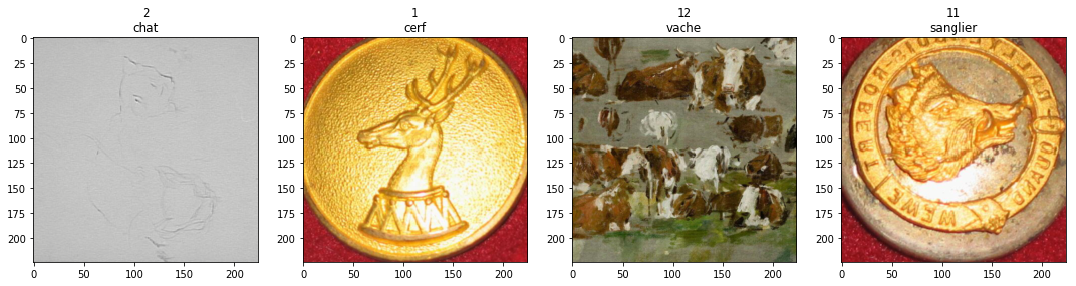

TEST SET
('C://Joconde//joconde//animal/test\\vache\\07120000195.jpg', 12)
('C://Joconde//joconde//animal/test\\ophidien\\01380001224.jpg', 9)
('C://Joconde//joconde//animal/test\\lion\\00170002695.jpg', 7)
('C://Joconde//joconde//animal/test\\sanglier\\M0794020563.jpg', 11)


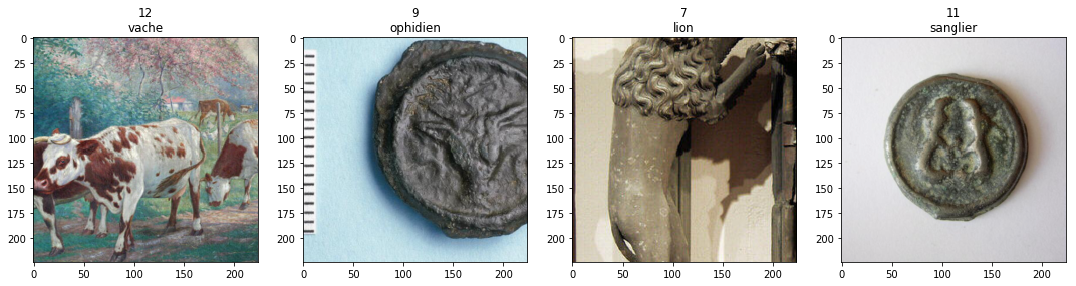

In [5]:
print('TRAIN SET')
MonaLIA.show_random_images(train_set, dataset_mean, dataset_std , is_small=False)

print ('TEST SET')
MonaLIA.show_random_images(test_set, dataset_mean, dataset_std, is_small=False)

### Define the network

Using Pytorh pretraned VGG16 with batch normalization.

In [6]:
net = torchvision.models.vgg16_bn(pretrained=True )
print(net)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256, kernel_size=(3, 3)

## Freeze parameters (if needed) and change the last layer's output
to the number of dataset classes

In [7]:
#Freeze all the layes
if(not full_training):
    for param in net.parameters():
        param.requires_grad = False
else:
    print('Full training')

In [8]:
# Replace the last layer and it will unfreeze it as well
net.classifier[len(net.classifier)-1] = nn.Linear(net.classifier[len(net.classifier)-1].in_features, class_count)

#Add layers
#net.classifier.add_module('7', nn.ReLU(True))
#net.classifier.add_module('8', nn.Dropout())
#net.classifier.add_module('9', nn.Linear(net.classifier[len(net.classifier)-3].out_features, class_count))
    
print(net)

for param in net.classifier.parameters():
    print(param.shape, param.requires_grad)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256, kernel_size=(3, 3)

### Training

In [13]:
use_cuda = torch.cuda.is_available()
if use_cuda:
    net = net.cuda()
    
print('Using cuda? ', use_cuda)

Using cuda?  True


In [14]:
learning_rate = 0.001

epoch_count = 10

criterion = nn.CrossEntropyLoss()

if (full_training):
    optimizer = optim.SGD(net.parameters() , lr=learning_rate, momentum=0.9)
else:
    optimizer = optim.SGD(net.classifier[len(net.classifier)-1].parameters() , lr=learning_rate, momentum=0.9)
    #optimizer = optim.SGD(net.classifier.parameters() , lr=learning_rate, momentum=0.9)

# Decay LR by a factor of 0.1 every 4 epochs
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=4, gamma=0.1)

In [ ]:
%%time
best_model_weights = copy.deepcopy(net.state_dict())
best_accuracy = 0.0

t0 = datetime.datetime.now()

for epoch in range(epoch_count):
    
    print('Epoch %d of %d' % (epoch+1, epoch_count) )
    #print('-', end='')
    
    # Each epoch has a training and validation phase
    for phase in ['train', 'val']:
        if phase == 'train':
            scheduler.step() 
            net.train()  # Set model to training mode
            data_loader = train_loader
            dataset_size = len(train_set)
        else:
            net.eval()   # Set model to evaluate mode
            data_loader = val_loader
            dataset_size = len(val_set)
            
        running_loss = 0.0
        running_corrects = 0

        for batch_idx, (img, target) in enumerate(data_loader):
            
            # use GPU if possible
            if use_cuda:
                img, target = img.cuda(), target.cuda()  
                
             # zero the parameter gradients
            optimizer.zero_grad()

            # autograd=true
            #img, target = Variable(img), Variable(target)

            with torch.set_grad_enabled(phase == 'train'):
                    
                #forward
                output = net(img)
              
                loss = criterion(output, target)
                _, preds = torch.max(output, 1)

                # backprop only for train phase
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

            # statistics
            running_loss += loss.item() * img.size(0)
            running_corrects += torch.sum(preds == target.data)
            #print('-', end='')
            if (batch_idx % 100 == 0):
                t1 = datetime.datetime.now()
                print('\rImages processed: %d      Time elapsed: %s' % (batch_idx*batch_size , str(t1-t0)), end='')
                

        epoch_loss = running_loss / dataset_size
        epoch_acc = running_corrects.double() / dataset_size
        
        print('')
        print('%s Loss: %.4f Acc: %.4f' % (phase, epoch_loss, epoch_acc) )

        # deep copy the model
        if phase == 'val' and epoch_acc > best_accuracy:
            best_accuracy = epoch_acc
            best_model_weights = copy.deepcopy(net.state_dict())
            print('*', end='')
    print() #end of epoch
    

print('Finished training')
print('Best validation accuracy: %.4f' % best_accuracy)

# load best model weights
net.load_state_dict(best_model_weights)

# Save before you forget
fn = '_last_training_%s.pth' % datetime.datetime.now().strftime('%b_%d_%H_%M')
torch.save(net.state_dict(), fn)

### Testing

In [15]:
total_cnt = 0
correct_cnt = 0

top_k  = min(5, len(test_set.classes))

classified = torch.empty(0, dtype=torch.long)

# Set model to evaluate mode
net.eval()  

for batch_idx, (img, target) in enumerate(test_loader):
    
    if use_cuda:
        img, target = img.cuda(), target.cuda()
        classified = classified.cuda()
        
    with torch.no_grad():
        #run model
        out = net(img)
        
        out = nn.functional.softmax(out,1) 

        pred_prob, pred_label = torch.max(out.data, 1)
        top5_prob, top5_label = torch.topk(out.data, top_k, 1) 
        
        
        if(top5_label[:, 0].max() > 13):
            print(top5_label)
            break
        
        total_cnt +=  target.size()[0]
        correct_cnt += (pred_label == target.data).sum()
  
        # display progress
        if total_cnt % 100 == 0 or total_cnt == len(test_loader):
            print( 'images total: {}, correct: {}, acc: {:.3f}%'.format(
                    total_cnt, correct_cnt, correct_cnt * 100.0 / total_cnt))
  
        target = target.view(target.shape[0],1) # transpoze target into column
        classified= torch.cat ( ( classified, 
                                   torch.cat((target,                                        # target
                                              top5_label ,                                   # list of top 5 classes
                                              (torch.gather(out, 1, target) * 10000).long(), # target prob
                                              (top5_prob * 10000).long()), 1)) , 0)    # list of probabilities of top 5 classes


        
print( 'images total: {}, correct: {}, acc: {:.3f}%'.format(
        total_cnt, correct_cnt, correct_cnt * 100.0 / total_cnt))

print('Finished testing')

images total: 100, correct: 30, acc: 30.000%
images total: 200, correct: 80, acc: 40.000%
images total: 224, correct: 92, acc: 41.000%
images total: 300, correct: 124, acc: 41.000%
images total: 400, correct: 141, acc: 35.000%
images total: 500, correct: 181, acc: 36.000%
images total: 600, correct: 214, acc: 35.000%
images total: 700, correct: 263, acc: 37.000%
images total: 800, correct: 315, acc: 39.000%
images total: 893, correct: 353, acc: 39.000%
Finished testing


### Show Statistics

In [16]:
classified = classified.cpu() 
prfs = metrics.precision_recall_fscore_support(y_true= classified[:,0],
                                               y_pred= classified[:,1],)

acc = metrics.accuracy_score(y_true= classified[:,0],
                             y_pred= classified[:,1])

output = pd.concat((pd.Series(test_set.classes) ,
           pd.Series(prfs[3].round(3)),         
           pd.Series(prfs[1].round(3)),
           pd.Series(prfs[0].round(3)),
           pd.Series(prfs[2].round(3)),
           pd.Series(acc.round(3))),
           
           axis=1 )
output.columns = ['class',  'support', 'recall', 'precision', 'f1 score', 'accuracy']
output

,class,support,recall,precision,f1 score,accuracy
0,aigle,60,0.283,0.293,0.288,0.395
1,cerf,70,0.471,0.423,0.446,NaN
2,chat,70,0.429,0.545,0.480,NaN
3,cheval,70,0.457,0.464,0.460,NaN
4,chien,70,0.214,0.294,0.248,NaN
5,chèvre,70,0.300,0.304,0.302,NaN
6,colombe,50,0.380,0.339,0.358,NaN
7,lion,70,0.357,0.357,0.357,NaN
8,mouton,70,0.314,0.301,0.308,NaN
9,ophidien,58,0.345,0.357,0.351,NaN


### Store classification data 
to be processd down the pipeline

In [ ]:
classified = classified.cpu() 
%store classified
%store test_set

classified.shape

### Save Network parameters

In [ ]:
torch.save(net.state_dict(), './Model Parameters/VGG16_bn_Joconde_artform_7_dense_trainig.pth')

### Reload Network parameters (if needed)

In [12]:
net.load_state_dict(torch.load('./Model Parameters/VGG16_bn_Joconde_animals_14_dense_training.pth'))

## Scrapbook

In [ ]:
import seaborn as sns

class_col_names = ['target', 'prediction', 'class2', 'class3', 'class4', 'class5',]
prob_col_names = ['target_prob','pred_prob', 'prob2', 'prob3', 'prob4', 'prob5']

#truncate the columns array if the number of classes is less than 5
class_col_names = class_col_names[0: classified.shape[1]//2 ] 
prob_col_names = prob_col_names[0 : classified.shape[1]//2]

col_names = class_col_names + prob_col_names

classified_df = pd.DataFrame(classified.numpy(), columns= col_names)

classified_df[prob_col_names] = classified_df[prob_col_names].apply(pd.to_numeric) * 0.0001
classified_df[class_col_names] = classified_df[class_col_names].apply(lambda row: row.apply(lambda x: test_set.classes[x]))

conf_matrix = pd.crosstab(index=classified_df.prediction, columns=classified_df.target, margins= True)

plt.figure(figsize = (10,7))
#conf_matrix
#sns.heatmap(conf_matrix, annot=True, cmap="YlGnBu")

conf_matrix_pct_target = pd.crosstab(index=classified_df.prediction, columns=classified_df.target)\
                        .div(conf_matrix.loc['All',:], axis=0) \
                        .dropna()\
                        .mul(100)\
                        .round(2)
sns.heatmap(conf_matrix_pct_target, annot=True, cmap="YlGnBu")
sns.clustermap(conf_matrix_pct_target, annot=True, cmap="YlGnBu", metric="correlation")

In [ ]:
?net.parameters

In [ ]:
net.classifier[len(net.classifier)-1].parameters() 